In [1]:
import cv2
import os
import torch,torchvision
import torch.nn as nn
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.nn import *
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import wandb
from ray import tune
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["WANDB_SILENT"] = "false"

In [2]:
device = torch.device('cuda')
IMG_SIZE = 224
PROJECT_NAME = 'Bob-Ross-Paintings'

In [3]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(0.9,0.9)])
# transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [4]:
def load_data(directory='./data/',IMG_SIZE = IMG_SIZE,transforms=transforms):
    idx = -1
    data = []
    for file in tqdm(os.listdir(directory)):
        file = directory + file
        img = cv2.imread(file,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        data.append(np.array(transforms(np.array(img))))
    return data

In [5]:
X = load_data(directory='./data/')
np.save('./data.npy',np.array(X))
X = np.load('./data.npy')

100%|██████████| 250/250 [00:01<00:00, 186.65it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


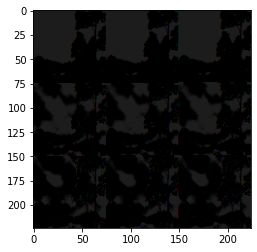

In [6]:
plt.imshow(torch.tensor(X[0]).view(IMG_SIZE,IMG_SIZE,3))

In [7]:
class Desc(nn.Module):
    def __init__(self,activation=nn.LeakyReLU,starter=16):
        super().__init__()
        self.dis = nn.Sequential(
            nn.Conv2d(3,4,3),
            activation(),
            nn.Conv2d(4,8,3),
            activation(),
        )
        self.dis2 = nn.Sequential(
            nn.Linear(387200,starter),
            activation(),
            nn.Linear(starter,starter*2),
            activation(),
            nn.Linear(starter*2,starter),
            activation(),
            nn.Linear(starter,1),
            nn.Sigmoid(),
        )
     
    def forward(self, x,shape=False):
        x = x.view(-1,3,IMG_SIZE,IMG_SIZE)
        x = self.dis(x)
        if shape:
            print(x.shape)
        x = x.view(-1,387200)
        x = self.dis2(x)
        return x
        
class Gen(nn.Module):
    def __init__(self,z_dim,activation=nn.LeakyReLU,starter=256):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim,starter),
            activation(),
            nn.Linear(starter,starter*2),
            activation(),
            nn.Linear(starter*2,starter*4),
            activation(),
            nn.Linear(starter*4,starter*2),
            activation(),
            nn.Linear(starter*2,IMG_SIZE*IMG_SIZE*3),
            nn.Tanh()
        )
 
    def forward(self, x):
        return self.gen(x)

In [8]:
# z_dim = 64
# gen = Gen(z_dim).to(device)
# desc = Desc().to(device)
# lr = 3e-4
# batch_size = 32
# epochs = 250
# criterion = nn.BCELoss()
# optimizer_gen = torch.optim.Adam(gen.parameters(),lr=lr)
# optimizer_desc = torch.optim.Adam(desc.parameters(),lr=lr)
# fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [9]:
from tqdm import tqdm

In [10]:
import random

In [11]:
# wandb.init(project=PROJECT_NAME,name=f'baseline-with-backward-pass-gen')
# for epoch in tqdm(range(25)):
#     for idx in range(0,len(X),batch_size):
#         X_batch = torch.tensor(np.array(X[idx:idx+batch_size])).view(-1,IMG_SIZE*IMG_SIZE*3).to(device)
#         batch_size = X_batch.shape[0]
#         noise = torch.randn(batch_size, z_dim).to(device)
#         fake = gen(noise)
#         desc_real = desc(X_batch).view(-1)
#         lossD_real = criterion(desc_real,torch.ones_like(desc_real))
#         desc_fake = desc(fake).view(-1)
#         lossD_fake = criterion(desc_fake,torch.zeros_like(desc_fake))
#         lossD = (lossD_real+lossD_fake)/2
#         desc.zero_grad()
#         lossD.backward(retain_graph=True)
#         wandb.log({'lossD':lossD.item()})
#         optimizer_desc.step()
#         output = desc(fake).view(-1)
#         lossG = criterion(output, torch.ones_like(output))
#         gen.zero_grad()
#         wandb.log({'lossG':lossG.item()})
#         lossG.backward()
#         wandb.log({'lossG':lossG.item()})
#         optimizer_gen.step()
# with torch.no_grad():
#     fake = gen(noise).view(-1,3,IMG_SIZE,IMG_SIZE)
#     img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
#     wandb.log({'img':wandb.Image(img_grid_fake)})

In [12]:
config={
#     "z_dim": [8,16,32,64,128,256,512],
#     'batch_size':[64,128,256,512,len(X),32,16,8],
#     'transforms':[0.2,0.4], # None,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
#     "Gen_starter": [32],
#     "Desc_starter": [8,16,32,64,128,256,512,1024],
#     "Desc_activation": [nn.LeakyReLU,nn.ReLU,nn.ELU,nn.PReLU,nn.ReLU6,nn.RReLU,nn.SELU,nn.CELU,nn.GELU,nn.SiLU],
#     "Gen_activation": [nn.LeakyReLU,nn.ReLU,nn.ELU,nn.PReLU,nn.ReLU6,nn.RReLU,nn.SELU,nn.CELU,nn.GELU,nn.SiLU],
#     'optimizer_gen':[optim.ASGD,optim.RMSprop,optim.Rprop,optim.Adadelta,optim.Adam,optim.AdamW,optim.Adamax,optim.Adagrad,optim.SGD],
#     'optimizer_desc':[optim.Adam,optim.AdamW,optim.Adamax,optim.Adagrad,optim.SGD,optim.ASGD,optim.RMSprop,optim.Rprop,optim.Adadelta],
#     'lr':[4e-5,4e-4,4e-3,4e-2,4e-1],
#     'criterion':[nn.BCELoss,nn.MSELoss,nn.L1Loss],
#     'epochs':[12,25,50,75,100,125,250,500]
}

In [13]:
def accuracy_fake(desc_fake):
    correct = 0
    total = 0
    preds = np.round(np.array(desc_fake.cpu().detach().numpy()))
    for pred in preds:
        if pred == 0:
            correct += 1
        total += 1
    return round(correct/total,3)
def accuracy_real(desc_real):
    correct = 0
    total = 0
    preds = np.round(np.array(desc_real.cpu().detach().numpy()))
    for pred in preds:
        if pred == 1:
            correct += 1
        total += 1
    return round(correct/total,3)

In [15]:
idx = -1
for class_name in config.keys():
    torch.cuda.empty_cache()
    print(class_name)
    for info in config[class_name]:
        print(info)
        if class_name == 'transforms':
            if info is None:
                transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
            else:
                transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(info,info)])
            X = load_data(directory='./data/',transforms=transforms)
            np.save('./data.npy',np.array(X))
            X = np.load('./data.npy')
        z_dim = 128
        gen_starter = 512
        gen_activation = nn.RReLU
        desc_starter = 32
        desc_activation = nn.LeakyReLU
        desc = Desc(starter=desc_starter,activation=desc_activation)
        lr = 4e-5
        epochs = 18
        batch_size = 128
        criterion = nn.BCELoss()
        if class_name == 'z_dim':
            z_dim = info
        if class_name == 'Gen_starter':
            gen_starter = info
        if class_name == 'Desc_starter':
            desc_starter = info
        if class_name == 'Desc_activation':
            desc_activation = info
        if class_name == 'Gen_activation':
            gen_activation = info
        if class_name == 'lr':
            lr = info
        if class_name == 'batch_size':
            batch_size = info
        if class_name == 'criterion':
            criterion = info()
        if class_name == 'epochs':
            epochs = info
        gen = Gen(z_dim,starter=gen_starter,activation=gen_activation)
        desc = Desc(starter=desc_starter,activation=desc_activation)
        optimizer_gen = torch.optim.AdamW(gen.parameters(),lr=lr)
        optimizer_desc = torch.optim.Adamax(desc.parameters(),lr=lr)
        gen.to(device)
        desc.to(device)
        if class_name == 'optimizer_gen':
            optimizer_gen = info(gen.parameters(),lr=lr)
        if class_name == 'optimizer_desc':
            optimizer_desc = info(desc.parameters(),lr=lr)
        fixed_noise = torch.randn(batch_size, z_dim).to(device)
        wandb.init(project=PROJECT_NAME,name=f'{class_name}-{info}')
        accuracy_reals = []
        accuracy_fakes = []
        torch.cuda.empty_cache()
        for epoch in tqdm(range(epochs)):
            torch.cuda.empty_cache()
            for idx in range(0,len(X),batch_size):
                X_batch = torch.tensor(np.array(X[idx:idx+batch_size])).view(-1,IMG_SIZE*IMG_SIZE*3).to(device)
                batch_size = X_batch.shape[0]
                noise = torch.randn(batch_size, z_dim).to(device)
                fake = gen(noise)
                desc_real = desc(X_batch).view(-1)
                lossD_real = criterion(desc_real,torch.ones_like(desc_real))
                desc_fake = desc(fake).view(-1)
                lossD_fake = criterion(desc_fake,torch.zeros_like(desc_fake))
                lossD = (lossD_real+lossD_fake)/2
                desc.zero_grad()
                lossD.backward(retain_graph=True)
                wandb.log({'lossD':lossD.item()})
                optimizer_desc.step()
                output = desc(fake).view(-1)
                lossG = criterion(output, torch.ones_like(output))
                gen.zero_grad()
                wandb.log({'lossG':lossG.item()})
                lossG.backward()
                wandb.log({'lossG':lossG.item()})
                optimizer_gen.step()
                wandb.log({'accuracy_fake':accuracy_fake(desc_fake)})
                wandb.log({'accuracy_real':accuracy_real(desc_real)})
        with torch.no_grad():
            fake = gen(noise).view(-1,3,IMG_SIZE,IMG_SIZE)
            img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
            wandb.log({'img_1':wandb.Image(fake[0].cpu())})
            wandb.log({'img':wandb.Image(img_grid_fake)})
            for _ in range(12):
                idx += 1
                noise = torch.randn(batch_size, z_dim).to(device)
                plt.figure(figsize=(25,12))
                plt.imshow(fake[0].cpu().view(IMG_SIZE,IMG_SIZE,3)*255)
                plt.savefig(f'./imgs/{idx}')